# GIM Mess Food-Waste Forecasting — Decision Tree Baseline

Run this notebook in **Google Colab** to train a simple, explainable model and export plots + model artifacts.

In [1]:
from pathlib import Path

PROJECT_ROOT = Path("/content")  # Colab working dir
ARTIFACTS = PROJECT_ROOT / "artifacts"
FIGS = PROJECT_ROOT / "reports" / "figures"

ARTIFACTS.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

print("ARTIFACTS →", ARTIFACTS.resolve())
print("FIGS      →", FIGS.resolve())


ARTIFACTS → /content/artifacts
FIGS      → /content/reports/figures


In [2]:
# --- Minimal setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib, json, io, requests

pd.set_option("display.max_columns", 200)

# Your GitHub repo (adjust branch if needed)
GITHUB_USER = "rohun-rajvanshi"
REPO        = "gim-food-waste-starter"
BRANCH      = "main"

RAW_BASE = f"https://raw.githubusercontent.com/{GITHUB_USER}/{REPO}/{BRANCH}"
CSV_PATH = "mess_waste_GIM_500.csv"     # it's at repo root, per your screenshot
CSV_URL  = f"{RAW_BASE}/{CSV_PATH}"
CSV_ALT  = None  # set to a local filename if you upload manually


In [3]:
def load_csv(csv_url, csv_alt=None):
    try:
        df = pd.read_csv(csv_url, parse_dates=['date'])
        print("Loaded from GitHub:", csv_url)
        return df
    except Exception as e:
        print("GitHub load failed:", e)

    if csv_alt is not None:
        try:
            df = pd.read_csv(csv_alt, parse_dates=['date'])
            print("Loaded local file:", csv_alt)
            return df
        except Exception as e:
            print("Local load failed:", e)

    # Last resort: manual upload
    from google.colab import files
    print("Upload your CSV (pick mess_waste_GIM_500.csv)")
    uploaded = files.upload()
    name = list(uploaded.keys())[0]
    return pd.read_csv(name, parse_dates=['date'])

df = load_csv(CSV_URL, CSV_ALT).sort_values('date').reset_index(drop=True)
df.head()


Loaded from GitHub: https://raw.githubusercontent.com/rohun-rajvanshi/gim-food-waste-starter/main/mess_waste_GIM_500.csv


,date,day_of_week,is_weekend,event_type,event_flag,temp_c,rain_mm,humidity,veg_main_dish,nonveg_main_dish,dessert,sweet_type,cooked_kg,consumed_kg,food_waste_kg
0,2024-07-01,Mon,0,Fest,1,28.4,35.1,87,"Jeera Rice, Dal Fry, Chapati",Scrambled Eggs/Banana,"Bread Pakoda, Ketchup",Fried,410.16,405.44,5.91
1,2024-07-02,Tue,0,NaN,0,30.7,0.0,77,Gravy- Gujarati Kadhi,Fish Kalia,"Bread Pakoda, Ketchup",Fried,408.56,396.67,12.84
2,2024-07-03,Wed,0,Fest,1,29.3,0.0,78,Chole Bhature,Bengali Fish Curry,Imarti,Fried,426.69,434.52,0.00
3,2024-07-04,Thu,0,NaN,0,29.5,25.9,82,Dry- Cabbage Masala,Fish Kalia,Fruit Custard,Milk-based,392.02,378.99,12.93
4,2024-07-05,Fri,0,NaN,0,28.1,0.0,79,"Moong Dal Chilla, Curd, Coriander Chutney",Egg Roast Curry,Mysore Pak,Fried,422.19,407.86,14.70


In [4]:
df2 = df.copy()

# Event flags
df2['is_exam']    = (df2['event_type'] == 'Exam').astype(int)
df2['is_holiday'] = (df2['event_type'] == 'Holiday').astype(int)
df2['is_fest']    = (df2['event_type'] == 'Fest').astype(int)

# Dessert flags (baseline = Other)
df2['sweet_milk']  = (df2['sweet_type'] == 'Milk-based').astype(int)
df2['sweet_fried'] = (df2['sweet_type'] == 'Fried').astype(int)
df2['sweet_halwa'] = (df2['sweet_type'] == 'Halwa-type').astype(int)

# Yesterday's waste (lag-1)
df2['yesterday_waste'] = df2['food_waste_kg'].shift(1)
df2 = df2.dropna(subset=['yesterday_waste']).reset_index(drop=True)

FEATURES = [
    'cooked_kg','temp_c','rain_mm','humidity',
    'is_weekend','is_exam','is_holiday','is_fest',
    'sweet_milk','sweet_fried','sweet_halwa',
    'yesterday_waste'
]

X = df2[FEATURES]
y = df2['food_waste_kg']
len(X), X.head(3)


(499,
    cooked_kg  temp_c  rain_mm  humidity  is_weekend  is_exam  is_holiday  \
 0     408.56    30.7      0.0        77           0        0           0   
 1     426.69    29.3      0.0        78           0        0           0   
 2     392.02    29.5     25.9        82           0        0           0   
 
    is_fest  sweet_milk  sweet_fried  sweet_halwa  yesterday_waste  
 0        0           0            1            0             5.91  
 1        1           0            1            0            12.84  
 2        0           1            0            0             0.00  )

In [5]:
n = len(df2)
i_tr = int(0.70*n)
i_va = int(0.85*n)

X_train, y_train = X.iloc[:i_tr], y.iloc[:i_tr]
X_val,   y_val   = X.iloc[i_tr:i_va], y.iloc[i_tr:i_va]
X_test,  y_test  = X.iloc[i_va:], y.iloc[i_va:]
dates_test = df2['date'].iloc[i_va:]

print(len(X_train), len(X_val), len(X_test))


349 75 75


In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def eval_block(y_true, y_hat, name):
    mae  = mean_absolute_error(y_true, y_hat)
    # Compat: some sklearn versions don't support `squared=False`
    rmse = np.sqrt(mean_squared_error(y_true, y_hat))
    r2   = r2_score(y_true, y_hat)
    print(f"{name}: MAE={mae:.2f} kg | RMSE={rmse:.2f} kg | R²={r2:.3f}")
    return {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}

# quick sweep for (max_depth, min_samples_leaf)
candidates = []
for md in [3,4,5,6,7]:
    for msl in [1,2,3,5]:
        m = DecisionTreeRegressor(max_depth=md, min_samples_leaf=msl, random_state=42)
        m.fit(X_train, y_train)
        mae = mean_absolute_error(y_val, m.predict(X_val))
        candidates.append((mae, md, msl))

best_mae, best_md, best_msl = sorted(candidates)[0]
print("Best (val) settings:", dict(max_depth=best_md, min_samples_leaf=best_msl, MAE=round(best_mae,2)))

best_tree = DecisionTreeRegressor(max_depth=best_md, min_samples_leaf=best_msl, random_state=42)
best_tree.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

test_pred = best_tree.predict(X_test)
metrics = eval_block(y_test, test_pred, f"Test (best tree md={best_md}, msl={best_msl})")
metrics


Best (val) settings: {'max_depth': 5, 'min_samples_leaf': 1, 'MAE': 6.66}
Test (best tree md=5, msl=1): MAE=6.40 kg | RMSE=8.10 kg | R²=0.786


{'MAE': 6.398675408669806, 'RMSE': 8.098453696701663, 'R2': 0.7863090664755418}

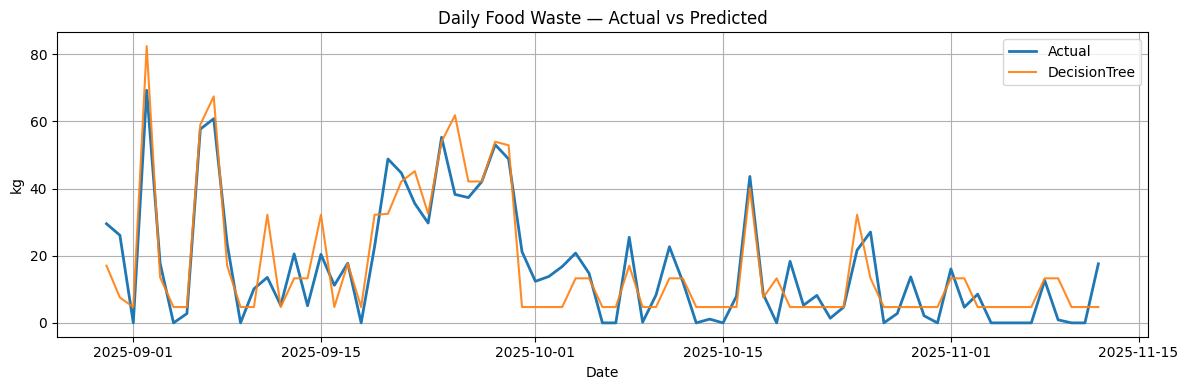

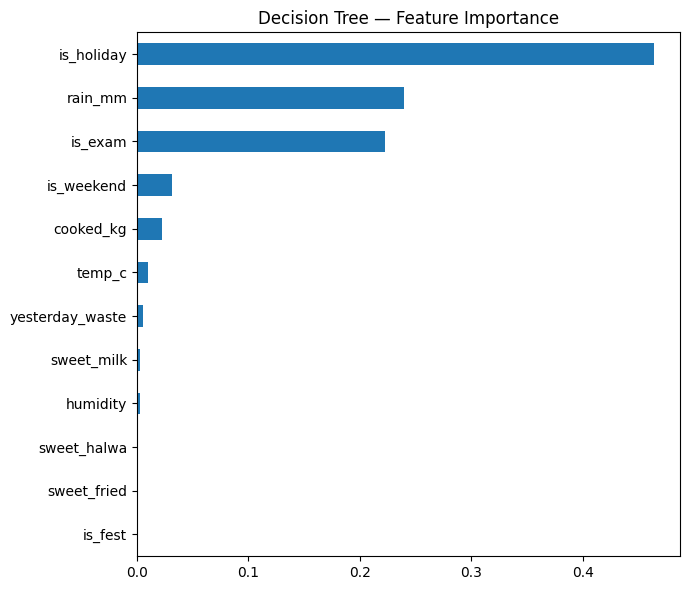

In [7]:
# Actual vs Predicted
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test.values, label="Actual", linewidth=2)
plt.plot(dates_test, test_pred, label="DecisionTree", alpha=0.9)
plt.title("Daily Food Waste — Actual vs Predicted")
plt.xlabel("Date"); plt.ylabel("kg")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig("fig_avp.png", dpi=150)
plt.show()

# Feature importance
imp = pd.Series(best_tree.feature_importances_, index=FEATURES).sort_values(ascending=True)
plt.figure(figsize=(7,6))
imp.plot(kind='barh')
plt.title("Decision Tree — Feature Importance")
plt.tight_layout()
plt.savefig("fig_importance.png", dpi=150)
plt.show()


In [8]:
# Save
joblib.dump({"model": best_tree, "columns": FEATURES}, "gim_tree_model.joblib")
with open("metrics.json","w") as f: json.dump(metrics, f, indent=2)
with open("feature_columns.json","w") as f: json.dump(FEATURES, f, indent=2)

print("Saved: gim_tree_model.joblib, metrics.json, feature_columns.json, fig_avp.png, fig_importance.png")

# Download to your machine (optional)
from google.colab import files
for f in ["gim_tree_model.joblib", "metrics.json", "feature_columns.json", "fig_avp.png", "fig_importance.png"]:
    files.download(f)


Saved: gim_tree_model.joblib, metrics.json, feature_columns.json, fig_avp.png, fig_importance.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
def predict_tomorrow_tree(
    cooked_kg,
    event_type="None",          # 'None','Exam','Holiday','Fest','Club Event'
    sweet_type="Milk-based",    # 'Milk-based','Fried','Halwa-type','Other'
    temp_c=30.0, rain_mm=5.0, humidity=85,
    model_bundle_path="gim_tree_model.joblib", df_history=df2
):
    bundle = joblib.load(model_bundle_path)
    model, cols = bundle["model"], bundle["columns"]
    row = {
        'cooked_kg': cooked_kg,
        'temp_c': temp_c,
        'rain_mm': rain_mm,
        'humidity': humidity,
        'is_weekend': int((df_history['date'].iloc[-1] + pd.Timedelta(days=1)).dayofweek >= 5),
        'is_exam':    int(event_type == 'Exam'),
        'is_holiday': int(event_type == 'Holiday'),
        'is_fest':    int(event_type == 'Fest'),
        'sweet_milk':  int(sweet_type == 'Milk-based'),
        'sweet_fried': int(sweet_type == 'Fried'),
        'sweet_halwa': int(sweet_type == 'Halwa-type'),
        'yesterday_waste': float(df_history['food_waste_kg'].iloc[-1]),
    }
    X_row = pd.DataFrame([row])[cols]
    return float(model.predict(X_row)[0])

# Example:
predict_tomorrow_tree(
    cooked_kg=410,
    event_type="Exam",
    sweet_type="Fried",
    temp_c=29.5, rain_mm=8.0, humidity=86
)


42.11

Post Feedback

In [10]:
# ## A0. Safe Imports and Paths (non-destructive)
import os, json, math, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

# Optional
try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False

# Reuse existing paths if they exist in globals; otherwise set defaults
try:
    ARTIFACTS
except NameError:
    ARTIFACTS = Path("artifacts")

try:
    FIGS
except NameError:
    FIGS = Path("reports") / "figures"

ARTIFACTS.mkdir(parents=True, exist_ok=True)
FIGS.mkdir(parents=True, exist_ok=True)

try:
    RANDOM_STATE
except NameError:
    RANDOM_STATE = 42

print("Using ARTIFACTS ->", ARTIFACTS)
print("Using FIGS      ->", FIGS)


Using ARTIFACTS -> /content/artifacts
Using FIGS      -> /content/reports/figures


In [11]:
# ## A1. Bootstrap Data/Columns from prior cells if missing
# Try to reuse df, target, date_col, preprocessor if defined; else infer.

if 'df' not in globals():
    # Fallback: try common data paths from the repo
    CANDS = [
        Path("data") / "mess_waste_GIM_500.csv",
        Path("mess_waste_GIM_500.csv"),
        Path("data") / "mess_waste_GIM_daily_exams.csv",
    ]
    src = next((p for p in CANDS if p.exists()), None)
    if src is None:
        raise FileNotFoundError("Could not find data. Please set df manually or place CSV under data/.")
    df = pd.read_csv(src)

# Detect/confirm target and date/event columns
POSSIBLE_TARGETS = ["food_waste_kg", "waste_kg", "leftover_kg", "wastage"]
DATE_CANDIDATES = ["date", "day", "timestamp", "dt"]
EVENT_CANDIDATES = ["event", "event_type", "special_event"]

if 'target' not in globals() or target not in df.columns:
    target = next((c for c in POSSIBLE_TARGETS if c in df.columns), None)
    if target is None:
        raise KeyError(f"Set target variable. Expected one of {POSSIBLE_TARGETS} in df.")

if 'date_col' not in globals() or date_col not in df.columns:
    date_col = next((c for c in DATE_CANDIDATES if c in df.columns), None)

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.sort_values(date_col).reset_index(drop=True)

event_col = next((c for c in EVENT_CANDIDATES if c in df.columns), None)

# Build/Reuse a robust preprocessor if none defined
if 'preprocessor' not in globals():
    X_tmp = df.drop(columns=[target])
    num_cols = X_tmp.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X_tmp.select_dtypes(include=["object", "category"]).columns.tolist()
    if date_col in num_cols: num_cols.remove(date_col)
    if date_col in cat_cols: cat_cols.remove(date_col)
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ])

print("Columns detected. target:", target, "| date_col:", date_col, "| event_col:", event_col)


Columns detected. target: food_waste_kg | date_col: date | event_col: event_type


In [12]:
# ## A2. Metrics & Utilities
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred)
    out = np.zeros_like(denom)
    mask = denom != 0
    out[mask] = diff[mask] / denom[mask]
    return 100.0 * np.mean(out)

def seasonal_naive(y_series, period=7):
    y = np.asarray(y_series)
    y_hat = np.full_like(y, np.nan, dtype=float)
    for t in range(period, len(y)):
        y_hat[t] = y[t - period]
    return y_hat

def interval_coverage(y_true, lo, hi):
    y = np.asarray(y_true)
    return float(np.mean((y >= lo) & (y <= hi)))

def waste_shortage(prepared, actual):
    prepared = np.asarray(prepared)
    actual = np.asarray(actual)
    waste = np.maximum(0.0, prepared - actual)
    shortage = np.maximum(0.0, actual - prepared)
    return waste, shortage


In [13]:
# ## A3. Rolling-Origin Backtest (RF) vs Seasonal-Naive
# Expanding window, H=1 day. Saves overall and monthly MAE/SMAPE.

# Feature engineering (light) — non-destructive to df
df_fe = df.copy()
if date_col is not None:
    d = df_fe[date_col].dt
    df_fe["dow"] = d.dayofweek
    df_fe["month"] = d.month
    df_fe["is_weekend"] = (d.dayofweek >= 5).astype(int)
    for win in (3, 7):
        df_fe[f"roll_mean_{win}"] = df_fe[target].rolling(win, min_periods=1).mean().shift(1)
        df_fe[f"roll_std_{win}"]  = df_fe[target].rolling(win, min_periods=1).std().shift(1)

y = df_fe[target].astype(float).values
X = df_fe.drop(columns=[target])

rf_bt = RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
rf_pipe = Pipeline([("prep", preprocessor), ("rf", rf_bt)])

y_naive = seasonal_naive(y, period=7)
preds_rf = np.full_like(y, np.nan, dtype=float)

start = 14  # two-week warmup
import time
t0 = time.perf_counter()

for t in range(start, len(df_fe)-1):
    train_idx = slice(0, t+1)
    test_idx = t+1
    rf_pipe.fit(X.iloc[train_idx], y[train_idx])
    preds_rf[test_idx] = rf_pipe.predict(X.iloc[[test_idx]])[0]

    if (t - start + 1) % 25 == 0:
        elapsed = time.perf_counter() - t0
        done = t - start + 1
        remaining = (len(df_fe)-1 - start) - done
        print(f"[A3] refits done: {done}, remaining: {remaining}, elapsed: {elapsed:.1f}s")


mask = ~np.isnan(preds_rf) & ~np.isnan(y_naive)
overall = {
    "RF_MAE": float(mean_absolute_error(y[mask], preds_rf[mask])),
    "RF_SMAPE": float(smape(y[mask], preds_rf[mask])),
    "Naive_MAE": float(mean_absolute_error(y[mask], y_naive[mask])),
    "Naive_SMAPE": float(smape(y[mask], y_naive[mask])),
}
overall["Improvement_MAE_%"] = 100.0 * (1 - overall["RF_MAE"] / overall["Naive_MAE"])
overall["Improvement_SMAPE_%"] = 100.0 * (1 - overall["RF_SMAPE"] / overall["Naive_SMAPE"])

months = (df_fe[date_col].dt.to_period("M").astype(str).values
          if date_col is not None else np.array(["ALL"]*len(df_fe)))

bt_df = pd.DataFrame({"month": months, "y": y, "rf": preds_rf, "naive": y_naive}).dropna()

monthly_rows = []
for m, g in bt_df.groupby("month"):
    monthly_rows.append({
        "month": m,
        "RF_MAE": float(mean_absolute_error(g["y"], g["rf"])),
        "RF_SMAPE": float(smape(g["y"], g["rf"])),
        "Naive_MAE": float(mean_absolute_error(g["y"], g["naive"])),
        "Naive_SMAPE": float(smape(g["y"], g["naive"])),
    })
monthly_df = pd.DataFrame(monthly_rows).sort_values("month")

pd.DataFrame([overall]).to_csv(ARTIFACTS / "backtest_overall.csv", index=False)
monthly_df.to_csv(ARTIFACTS / "backtest_monthly.csv", index=False)
print("Saved:", ARTIFACTS / "backtest_overall.csv")
print("Saved:", ARTIFACTS / "backtest_monthly.csv")


[A3] refits done: 25, remaining: 460, elapsed: 24.0s
[A3] refits done: 50, remaining: 435, elapsed: 51.2s
[A3] refits done: 75, remaining: 410, elapsed: 86.0s
[A3] refits done: 100, remaining: 385, elapsed: 117.1s
[A3] refits done: 125, remaining: 360, elapsed: 152.2s
[A3] refits done: 150, remaining: 335, elapsed: 194.5s
[A3] refits done: 175, remaining: 310, elapsed: 238.4s
[A3] refits done: 200, remaining: 285, elapsed: 284.6s
[A3] refits done: 225, remaining: 260, elapsed: 335.1s
[A3] refits done: 250, remaining: 235, elapsed: 393.4s
[A3] refits done: 275, remaining: 210, elapsed: 452.9s
[A3] refits done: 300, remaining: 185, elapsed: 518.1s
[A3] refits done: 325, remaining: 160, elapsed: 585.0s
[A3] refits done: 350, remaining: 135, elapsed: 655.3s
[A3] refits done: 375, remaining: 110, elapsed: 730.3s
[A3] refits done: 400, remaining: 85, elapsed: 809.4s
[A3] refits done: 425, remaining: 60, elapsed: 893.1s
[A3] refits done: 450, remaining: 35, elapsed: 985.0s
[A3] refits done: 4

In [14]:
# ## A4-ultrafast. Conformal Intervals from RF Residuals (no extra models)
# Requires preds_rf from A3 backtest; writes the same outputs.

assert 'preds_rf' in globals(), "Run A3 to get rolling RF predictions first."

bt = pd.DataFrame({"y": y, "rf": preds_rf}).dropna()
resid = bt["y"] - bt["rf"]

# Two-sided quantiles for residuals (non-symmetric intervals)
alpha = 0.10  # 90% interval
q_low  = np.quantile(resid, alpha/2)
q_high = np.quantile(resid, 1 - alpha/2)

# Build intervals around RF prediction
q_lo_conf = preds_rf + q_low
q_hi_conf = preds_rf + q_high
q_md_conf = preds_rf

mask_c = ~np.isnan(q_lo_conf) & ~np.isnan(q_hi_conf)
coverage90 = float(np.mean((y[mask_c] >= q_lo_conf[mask_c]) & (y[mask_c] <= q_hi_conf[mask_c])))

with open(ARTIFACTS / "interval_coverage.json", "w") as f:
    json.dump({"coverage90": coverage90}, f, indent=2)
print("Saved:", ARTIFACTS / "interval_coverage.json")

# Policy sim with conformal intervals
lams = np.linspace(0, 1, 6)
policy = []
for lam in lams:
    prepared = q_md_conf.copy()
    prepared[mask_c] = q_md_conf[mask_c] + lam * (q_hi_conf[mask_c] - q_md_conf[mask_c])
    waste = np.maximum(0, prepared[mask_c] - y[mask_c])
    shortage = np.maximum(0, y[mask_c] - prepared[mask_c])
    policy.append({
        "lambda": float(lam),
        "avg_waste": float(np.mean(waste)),
        "avg_shortage": float(np.mean(shortage)),
        "efficiency_%": float(100.0 * (1 - (np.mean(waste) / (np.mean(y[mask_c]) + 1e-8)))),
    })
pd.DataFrame(policy).to_csv(ARTIFACTS / "policy_simulation.csv", index=False)
print("Saved:", ARTIFACTS / "policy_simulation.csv")


Saved: /content/artifacts/interval_coverage.json
Saved: /content/artifacts/policy_simulation.csv


In [15]:
# ## A5-robust. Event Effects + Hierarchical Pooling Fallback (no dependency on A4)
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# 0) Guards: make sure required objects exist
assert 'df_fe' in globals(), "df_fe not found. Re-run data/feature cells."
assert 'y' in globals(), "y not found. Re-run data/feature cells."
assert 'X' in globals(), "X not found. Re-run data/feature cells."
assert 'preprocessor' in globals(), "preprocessor not found. Re-run setup cells."
ARTIFACTS = (Path("/content") / "artifacts") if 'ARTIFACTS' not in globals() else ARTIFACTS
ARTIFACTS.mkdir(parents=True, exist_ok=True)

# 1) Choose prediction source: q_md (A4) -> preds_rf (A3) -> fallback RF
pred_source = None
pred_series = None

def _finite_any(a):
    try:
        return np.isfinite(np.asarray(a, dtype=float)).any()
    except Exception:
        return False

if 'q_md' in globals() and _finite_any(q_md):
    pred_series = pd.Series(q_md, name="pred")
    pred_source = "q_md (quantile median)"
elif 'preds_rf' in globals() and _finite_any(preds_rf):
    pred_series = pd.Series(preds_rf, name="pred")
    pred_source = "preds_rf (rolling RF)"
else:
    # Fast fallback: fit a light RF once and predict in-sample
    rf_tmp = Pipeline([
        ("prep", preprocessor),
        ("rf", RandomForestRegressor(n_estimators=300, max_depth=12,
                                     random_state=RANDOM_STATE, n_jobs=-1))
    ])
    rf_tmp.fit(X, y)
    pred_series = pd.Series(rf_tmp.predict(X), name="pred")
    pred_source = "in-sample RF fallback"

print(f"[A5] Using prediction source: {pred_source}")

# 2) Event column (create synthetic if missing)
event_col_safe = None
if 'event_col' in globals() and event_col in df_fe.columns:
    event_col_safe = event_col
else:
    df_fe = df_fe.copy()
    df_fe["event_synth"] = "Normal"
    event_col_safe = "event_synth"

# 3) Build residual frame
date_vals = (df_fe[date_col] if ('date_col' in globals() and date_col in df_fe.columns)
             else pd.RangeIndex(len(df_fe)))
bt_ev = pd.DataFrame({
    "date": date_vals,
    "y": np.asarray(y, dtype=float),
    "pred": np.asarray(pred_series, dtype=float),
    "event": df_fe[event_col_safe]
}).dropna()

bt_ev["resid"] = bt_ev["y"] - bt_ev["pred"]

# 4) Hierarchical (empirical Bayes) shrinkage by event
evt_stats = (bt_ev.groupby("event")["resid"]
             .agg(["mean","std","count"])
             .reset_index()
             .rename(columns={"mean":"resid_mean","std":"resid_std","count":"n"}))

global_mean = bt_ev["resid"].mean()
k = max(1.0, evt_stats["n"].median())  # prior strength ~ median group size
evt_stats["global_mean"] = global_mean
evt_stats["shrink_mean"] = (evt_stats["n"]/(evt_stats["n"]+k))*evt_stats["resid_mean"] \
                           + (k/(evt_stats["n"]+k))*global_mean

# 5) Save
outp = ARTIFACTS / "event_residuals.csv"
evt_stats.to_csv(outp, index=False)
print("Saved:", outp)


[A5] Using prediction source: preds_rf (rolling RF)
Saved: /content/artifacts/event_residuals.csv


In [16]:
# ## A6. Explainability (SHAP if available, else Permutation) + Top Errors + Perf Tracker

import time, sys
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

# --------------------- #
# Perf tracker utility
# --------------------- #
def perf_tracker(iterable, total=None, tag="Loop"):
    """
    Lightweight progress + ETA tracker for long loops.
    Usage:
        for i in perf_tracker(range(100), tag="Backtest"):
            ...
    """
    start = time.perf_counter()
    if total is None:
        try:
            total = len(iterable)
        except Exception:
            total = None

    for i, item in enumerate(iterable, 1):
        if i == 1 or i % 10 == 0 or (total and i == total):
            elapsed = time.perf_counter() - start
            if total:
                rate = elapsed / i
                remaining = (total - i) * rate
                eta = f" | ETA: {remaining/60:.1f} min" if remaining > 60 else f" | ETA: {remaining:.1f}s"
            else:
                eta = ""
            sys.stdout.write(f"\r[{tag}] step {i}/{total or '?'} | elapsed: {elapsed:.1f}s{eta}")
            sys.stdout.flush()
        yield item
    print(f"\n[{tag}] done in {time.perf_counter()-start:.1f}s")

# --------------------- #
# Fit explainability model
# --------------------- #

rf_full = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=400,     # reduce from 600 for speed
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

t0 = time.perf_counter()
print(" Fitting Random Forest for explainability...")
rf_full.fit(X, y)
print(f"RF fitted in {time.perf_counter()-t0:.1f}s")

# --------------------- #
# Get feature names
# --------------------- #
try:
    num_names = list(preprocessor.transformers_[0][2])
    cat_base = preprocessor.transformers_[1][2]
    ohe = preprocessor.named_transformers_["cat"]
    cat_names = ohe.get_feature_names_out(cat_base).tolist()
    feat_names = num_names + cat_names
except Exception:
    feat_names = [f"f{i}" for i in range(rf_full.named_steps["rf"].n_features_in_)]

# --------------------- #
# Compute importance (SHAP → fallback permutation)
# --------------------- #
importance_df = None
if "shap" in globals() and SHAP_AVAILABLE:
    try:
        import shap
        print("Running SHAP (TreeExplainer)...")
        explainer = shap.TreeExplainer(rf_full.named_steps["rf"])
        X_tr = preprocessor.transform(X)
        if hasattr(X_tr, "toarray"): X_tr = X_tr.toarray()
        idx = np.linspace(0, X_tr.shape[0]-1, min(500, X_tr.shape[0])).astype(int)
        sv = explainer.shap_values(X_tr[idx])
        shap_abs = np.mean(np.abs(sv), axis=0)
        importance_df = pd.DataFrame({"feature": feat_names, "importance": shap_abs}).sort_values("importance", ascending=False)
        print("SHAP completed.")
    except Exception as e:
        print("SHAP error; falling back to permutation:", e)

if importance_df is None:
    print("Computing permutation importance (fast mode)...")
    Xp = preprocessor.transform(X)
    if hasattr(Xp, "toarray"): Xp = Xp.toarray()
    perm = permutation_importance(
        rf_full.named_steps["rf"],
        Xp, y,
        n_repeats=3,  # lower repeats = faster
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    k = min(len(feat_names), perm.importances_mean.shape[0])
    importance_df = pd.DataFrame({
        "feature": feat_names[:k],
        "importance": perm.importances_mean[:k]
    }).sort_values("importance", ascending=False)
    print("Permutation importance done.")

importance_df.to_csv(ARTIFACTS / "feature_importance.csv", index=False)
print("Saved:", ARTIFACTS / "feature_importance.csv")

# --------------------- #
# Top mispredictions
# --------------------- #
print("Building top mispredictions table...")

# prefer rolling RF preds if present; else quantile median; else in-sample
if "preds_rf" in globals() and np.isfinite(pd.Series(preds_rf)).any():
    pred_series = pd.Series(preds_rf, name="pred")
elif "q_md" in globals() and np.isfinite(pd.Series(q_md)).any():
    pred_series = pd.Series(q_md, name="pred")
else:
    pred_series = pd.Series(rf_full.predict(X), name="pred")

date_vals = df_fe[date_col] if (date_col is not None and date_col in df_fe.columns) else pd.RangeIndex(len(df_fe))
err_df = pd.DataFrame({"date": date_vals, "y": y, "pred": pred_series}).dropna()
err_df["abs_err"] = np.abs(err_df["y"] - err_df["pred"])

TOPK = 15
context_cols = [c for c in df_fe.columns if c != target]

top_err = (
    err_df.sort_values("abs_err", ascending=False)
          .head(TOPK)
          .merge(df_fe[context_cols], left_index=True, right_index=True, how="left")
)

top_err.to_csv(ARTIFACTS / "top_mispredictions.csv", index=False)
print("Saved:", ARTIFACTS / "top_mispredictions.csv")

print("\nA6 complete.")


 Fitting Random Forest for explainability...
RF fitted in 3.5s
Running SHAP (TreeExplainer)...
SHAP completed.
Saved: /content/artifacts/feature_importance.csv
Building top mispredictions table...
Saved: /content/artifacts/top_mispredictions.csv

A6 complete.


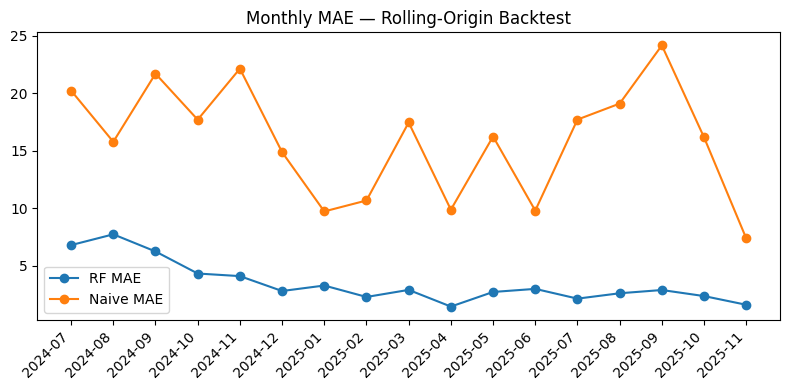

Saved: /content/reports/figures/monthly_mae.png


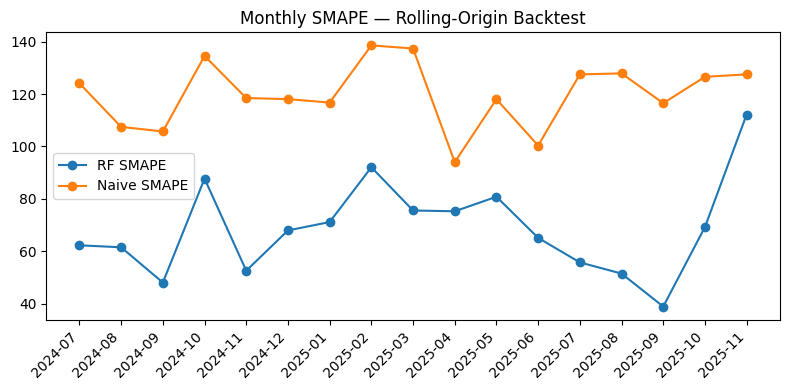

Saved: /content/reports/figures/monthly_smape.png


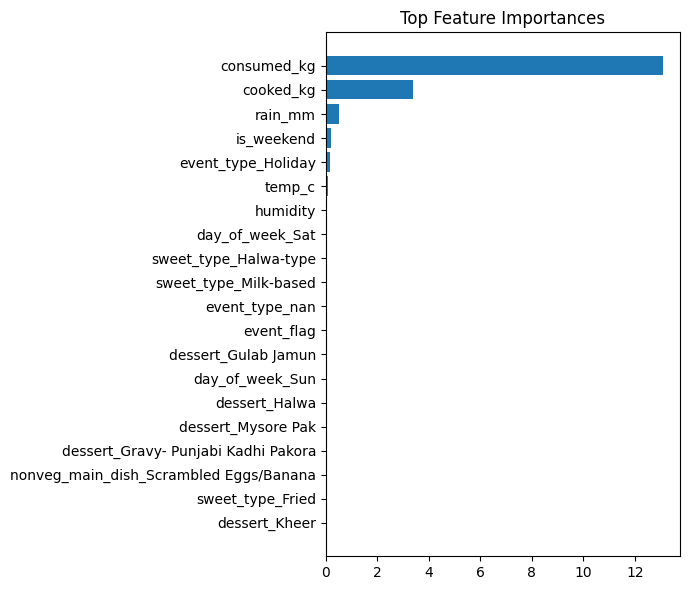

Saved: /content/reports/figures/feature_importance.png


In [17]:
# ## A7. Plots for Overleaf
import matplotlib.pyplot as plt

# Monthly MAE/SMAPE
try:
    monthly_df = pd.read_csv(ARTIFACTS / "backtest_monthly.csv")
    if not monthly_df.empty:
        plt.figure(figsize=(8,4))
        plt.plot(monthly_df["month"], monthly_df["RF_MAE"], marker='o', label="RF MAE")
        plt.plot(monthly_df["month"], monthly_df["Naive_MAE"], marker='o', label="Naive MAE")
        plt.xticks(rotation=45, ha='right')
        plt.title("Monthly MAE — Rolling-Origin Backtest")
        plt.legend()
        plt.tight_layout()
        p1 = FIGS / "monthly_mae.png"
        plt.savefig(p1, dpi=150)
        plt.show()
        print("Saved:", p1)

        plt.figure(figsize=(8,4))
        plt.plot(monthly_df["month"], monthly_df["RF_SMAPE"], marker='o', label="RF SMAPE")
        plt.plot(monthly_df["month"], monthly_df["Naive_SMAPE"], marker='o', label="Naive SMAPE")
        plt.xticks(rotation=45, ha='right')
        plt.title("Monthly SMAPE — Rolling-Origin Backtest")
        plt.legend()
        plt.tight_layout()
        p2 = FIGS / "monthly_smape.png"
        plt.savefig(p2, dpi=150)
        plt.show()
        print("Saved:", p2)
except Exception as e:
    print("Monthly plots skipped:", e)

# Quantile interval band (last 60 preds if available)
try:
    if 'q_lo' in globals() and 'q_md' in globals() and 'q_hi' in globals():
        mask_q = ~np.isnan(q_lo) & ~np.isnan(q_md) & ~np.isnan(q_hi)
        idxs = np.where(mask_q)[0]
        if len(idxs) > 0:
            tail = idxs[-min(60, len(idxs)):]  # last 60
            plt.figure(figsize=(9,4))
            plt.fill_between(tail, q_lo[tail], q_hi[tail], alpha=0.3, label="90% PI")
            plt.plot(tail, y[tail], label="Actual")
            plt.plot(tail, q_md[tail], label="Median")
            plt.title("Quantile Intervals (last window)")
            plt.legend()
            plt.tight_layout()
            p3 = FIGS / "quantile_intervals.png"
            plt.savefig(p3, dpi=150)
            plt.show()
            print("Saved:", p3)
except Exception as e:
    print("Quantile plot skipped:", e)

# Feature importance bar (top 20)
try:
    imp = pd.read_csv(ARTIFACTS / "feature_importance.csv").head(20).iloc[::-1]
    plt.figure(figsize=(7,6))
    plt.barh(imp["feature"], imp["importance"])
    plt.title("Top Feature Importances")
    plt.tight_layout()
    p4 = FIGS / "feature_importance.png"
    plt.savefig(p4, dpi=150)
    plt.show()
    print("Saved:", p4)
except Exception as e:
    print("Importance plot skipped:", e)


In [18]:
# ## A8. Outputs Index
index = {
    "backtest_overall": str(ARTIFACTS / "backtest_overall.csv"),
    "backtest_monthly": str(ARTIFACTS / "backtest_monthly.csv"),
    "interval_coverage": str(ARTIFACTS / "interval_coverage.json"),
    "policy_simulation": str(ARTIFACTS / "policy_simulation.csv"),
    "event_residuals": str(ARTIFACTS / "event_residuals.csv"),
    "feature_importance": str(ARTIFACTS / "feature_importance.csv"),
    "top_mispredictions": str(ARTIFACTS / "top_mispredictions.csv"),
    "fig_monthly_mae": str(FIGS / "monthly_mae.png"),
    "fig_monthly_smape": str(FIGS / "monthly_smape.png"),
    "fig_quantile_intervals": str(FIGS / "quantile_intervals.png"),
    "fig_feature_importance": str(FIGS / "feature_importance.png"),
}
print(json.dumps(index, indent=2))


{
  "backtest_overall": "/content/artifacts/backtest_overall.csv",
  "backtest_monthly": "/content/artifacts/backtest_monthly.csv",
  "interval_coverage": "/content/artifacts/interval_coverage.json",
  "policy_simulation": "/content/artifacts/policy_simulation.csv",
  "event_residuals": "/content/artifacts/event_residuals.csv",
  "feature_importance": "/content/artifacts/feature_importance.csv",
  "top_mispredictions": "/content/artifacts/top_mispredictions.csv",
  "fig_monthly_mae": "/content/reports/figures/monthly_mae.png",
  "fig_monthly_smape": "/content/reports/figures/monthly_smape.png",
  "fig_quantile_intervals": "/content/reports/figures/quantile_intervals.png",
  "fig_feature_importance": "/content/reports/figures/feature_importance.png"
}


In [19]:
!ls -R /content/artifacts || true
!ls -R /content/reports/figures || true


/content/artifacts:
backtest_monthly.csv  feature_importance.csv  top_mispredictions.csv
backtest_overall.csv  interval_coverage.json
event_residuals.csv   policy_simulation.csv
/content/reports/figures:
feature_importance.png	monthly_mae.png  monthly_smape.png


In [20]:
!zip -r /content/all_content.zip /content -x "/content/sample_data/*"
from google.colab import files
files.download('/content/all_content.zip')


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/.last_update_check.json (deflated 23%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.11.07/ (stored 0%)
  adding: content/.config/logs/2025.11.07/14.30.29.487903.log (deflated 57%)
  adding: content/.config/logs/2025.11.07/14.30.06.191154.log (deflated 58%)
  adding: content/.config/logs/2025.11.07/14.29.37.882815.log (deflated 92%)
  adding: content/.config/logs/2025.11.07/14.30.19.353226.log (deflated 58%)
  adding: content/.config/logs/2025.11.07/14.30.30.258639.log (deflated 56%)
  adding: content/.config/logs/2025.11.07/14.30.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>